--------------------------------------------------
ІНСТРУКЦІЯ КОРИСТУВАЧА:
--------------------------------------------------
1. Використовуйте ліву колонку слайдерів для налаштування параметрів гармоніки (A, w, phi).
2. Права колонка слайдерів керує шумом та параметрами фільтра.
   - 'Середнє шуму' зміщує шум вгору/вниз.
   - 'Дисперсія (std)' змінює розкид шуму.
   - 'Частота фільтру' визначає, наскільки сильно згладжується сигнал.
3. Чекбокс 'Показати шум' вмикає або вимикає відображення шумової компоненти.
   Зверніть увагу: фільтрація відбувається по тому сигналу, що відображено.
4. Кнопка 'Reset' повертає всі слайдери до початкових значень.
5. Особливість: Малюнок шуму (патерн) фіксований.
   Якщо ви змінюєте частоту гармоніки, 'тремтіння' шуму залишається на тих самих місцях.
--------------------------------------------------


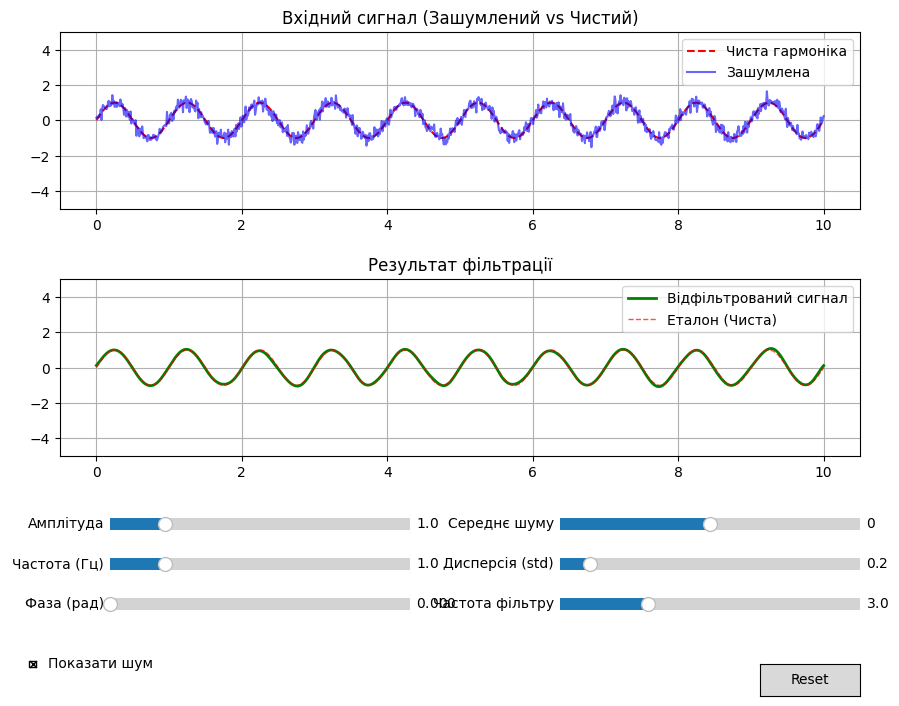

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from scipy import signal

# --- Налаштування початкових параметрів ---
t = np.linspace(0, 10, 1000)  # Часовий проміжок
init_amplitude = 1.0
init_frequency = 1.0
init_phase = 0.0
init_noise_mean = 0.0
init_noise_std = 0.2  # Корінь з дисперсії (коваріації)
init_cutoff = 3.0     # Частота зрізу фільтра

# Глобальна змінна для зберігання "базового" патерну шуму.
# Це дозволяє змінювати амплітуду шуму (std), не змінюючи його випадковий малюнок.
base_noise_pattern = np.random.normal(0, 1, len(t))

def harmonic_with_noise(t, amplitude, frequency, phase, noise_mean, noise_std, show_noise):
    """
    Генерує гармоніку та додає шум на основі збереженого патерну.
    """
    # Чиста гармоніка: y = A * sin(wt + phi)
    clean_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)
    
    # Розрахунок шуму на основі базового патерну
    # (noise_std тут виступає як множник для дисперсії)
    current_noise = base_noise_pattern * noise_std + noise_mean
    
    if show_noise:
        noisy_signal = clean_signal + current_noise
    else:
        noisy_signal = clean_signal
        
    return clean_signal, noisy_signal

def apply_filter(data, cutoff_freq, fs=100.0, order=4):
    """
    Застосовує фільтр низьких частот Баттерворта.
    fs - частота дискретизації (100 точок на секунду в нашому випадку t=0..10, N=1000)
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    # Захист від некоректних частот
    if normal_cutoff >= 1: normal_cutoff = 0.99
    if normal_cutoff <= 0: normal_cutoff = 0.01
    
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    # filtfilt використовується для фільтрації без фазового зсуву
    y = signal.filtfilt(b, a, data)
    return y

# --- Створення графічного інтерфейсу ---

# Створюємо фігуру та два підграфіки
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(left=0.1, bottom=0.35, hspace=0.4) # Залишаємо місце знизу для слайдерів

# Графік 1: Гармоніка (чиста + зашумлена)
l_clean, = ax1.plot(t, np.zeros_like(t), 'r--', lw=1.5, label='Чиста гармоніка')
l_noisy, = ax1.plot(t, np.zeros_like(t), 'b-', alpha=0.6, label='Зашумлена')
ax1.set_title('Вхідний сигнал (Зашумлений vs Чистий)')
ax1.set_ylim(-5, 5)
ax1.legend(loc='upper right')
ax1.grid(True)

# Графік 2: Результат фільтрації
l_filtered, = ax2.plot(t, np.zeros_like(t), 'g-', lw=2, label='Відфільтрований сигнал')
l_clean_ref, = ax2.plot(t, np.zeros_like(t), 'r--', lw=1, alpha=0.7, label='Еталон (Чиста)')
ax2.set_title('Результат фільтрації')
ax2.set_ylim(-5, 5)
ax2.legend(loc='upper right')
ax2.grid(True)

# --- Елементи керування (Слайдери та кнопки) ---

# Координати для елементів [left, bottom, width, height]
axcolor = 'lightgoldenrodyellow'

# Слайдери гармоніки
ax_amp = plt.axes([0.15, 0.25, 0.3, 0.03], facecolor=axcolor)
ax_freq = plt.axes([0.15, 0.20, 0.3, 0.03], facecolor=axcolor)
ax_phase = plt.axes([0.15, 0.15, 0.3, 0.03], facecolor=axcolor)

s_amp = Slider(ax_amp, 'Амплітуда', 0.1, 5.0, valinit=init_amplitude)
s_freq = Slider(ax_freq, 'Частота (Гц)', 0.1, 5.0, valinit=init_frequency)
s_phase = Slider(ax_phase, 'Фаза (рад)', 0.0, 2*np.pi, valinit=init_phase)

# Слайдери шуму та фільтру
ax_noise_mean = plt.axes([0.6, 0.25, 0.3, 0.03], facecolor=axcolor)
ax_noise_std = plt.axes([0.6, 0.20, 0.3, 0.03], facecolor=axcolor)
ax_filt_cut = plt.axes([0.6, 0.15, 0.3, 0.03], facecolor=axcolor)

s_noise_mean = Slider(ax_noise_mean, 'Середнє шуму', -2.0, 2.0, valinit=init_noise_mean)
s_noise_std = Slider(ax_noise_std, 'Дисперсія (std)', 0.0, 2.0, valinit=init_noise_std)
s_filt = Slider(ax_filt_cut, 'Частота фільтру', 0.1, 10.0, valinit=init_cutoff)

# Чекбокс
ax_check = plt.axes([0.05, 0.05, 0.15, 0.08], frameon=False)
check = CheckButtons(ax_check, ['Показати шум'], [True])

# Кнопка Reset
ax_reset = plt.axes([0.8, 0.05, 0.1, 0.04])
button = Button(ax_reset, 'Reset', hovercolor='0.975')

# --- Логіка оновлення ---

def update(val=None):
    # Зчитуємо значення зі слайдерів
    amp = s_amp.val
    freq = s_freq.val
    phase = s_phase.val
    
    n_mean = s_noise_mean.val
    n_std = s_noise_std.val
    
    filt_cutoff = s_filt.val
    
    # Перевіряємо статус чекбокса (get_status повертає список [True/False])
    show_noise_flag = check.get_status()[0]
    
    # 1. Генеруємо дані
    clean, noisy = harmonic_with_noise(t, amp, freq, phase, n_mean, n_std, show_noise_flag)
    
    # 2. Фільтруємо (фільтруємо саме noisy версію)
    # Якщо шум вимкнено чекбоксом, фільтр буде просто згладжувати чисту синусоїду
    filtered = apply_filter(noisy, filt_cutoff)
    
    # 3. Оновлюємо дані на графіках
    l_clean.set_ydata(clean)
    l_noisy.set_ydata(noisy)
    
    l_filtered.set_ydata(filtered)
    l_clean_ref.set_ydata(clean) # Еталон на другому графіку
    
    # Перемальовуємо
    fig.canvas.draw_idle()

# Прив'язка події зміни до слайдерів
s_amp.on_changed(update)
s_freq.on_changed(update)
s_phase.on_changed(update)
s_noise_mean.on_changed(update)
s_noise_std.on_changed(update)
s_filt.on_changed(update)
check.on_clicked(update)

# --- Логіка Reset ---
def reset(event):
    s_amp.reset()
    s_freq.reset()
    s_phase.reset()
    s_noise_mean.reset()
    s_noise_std.reset()
    s_filt.reset()
    # Примітка: чекбокс в matplotlib складніше скинути програмно в одну лінію, 
    # але основні параметри скинуться.

button.on_clicked(reset)

# --- Інструкція для користувача в консолі ---
print("-" * 50)
print("ІНСТРУКЦІЯ КОРИСТУВАЧА:")
print("-" * 50)
print("1. Використовуйте ліву колонку слайдерів для налаштування параметрів гармоніки (A, w, phi).")
print("2. Права колонка слайдерів керує шумом та параметрами фільтра.")
print("   - 'Середнє шуму' зміщує шум вгору/вниз.")
print("   - 'Дисперсія (std)' змінює розкид шуму.")
print("   - 'Частота фільтру' визначає, наскільки сильно згладжується сигнал.")
print("3. Чекбокс 'Показати шум' вмикає або вимикає відображення шумової компоненти.")
print("   Зверніть увагу: фільтрація відбувається по тому сигналу, що відображено.")
print("4. Кнопка 'Reset' повертає всі слайдери до початкових значень.")
print("5. Особливість: Малюнок шуму (патерн) фіксований.")
print("   Якщо ви змінюєте частоту гармоніки, 'тремтіння' шуму залишається на тих самих місцях.")
print("-" * 50)

# Перший виклик для ініціалізації
update()

plt.show()